In [43]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Time Series data with single variable

## Simulated data generation

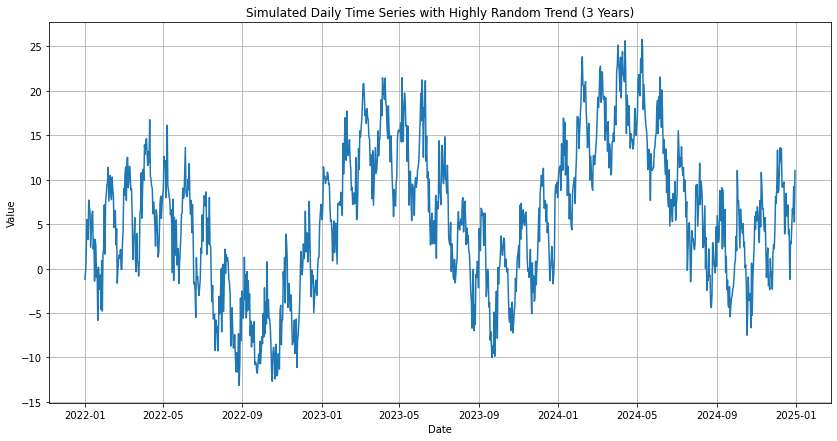

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create the date range for the simulated data
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Random walk without drift
# higher loc may result in increasing trend
trend_steps = np.random.normal(loc=[0], scale=0.2, size=len(dates))
trend = np.cumsum(trend_steps)

# based on the sin method to create a smooth trend for the seasonality
yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
monthly_seasonality = 5 * np.sin(2 * np.pi * dates.day / 30)

# create the noise with antoher scale 
noise = np.random.normal(loc=0, scale=2, size=len(dates))

# add up the trend, seasonality and noise for the data
data = trend + yearly_seasonality + monthly_seasonality + noise

# convert it into a dataframe with the date and values columns
time_series = pd.DataFrame(data, index=dates)
time_series = time_series.reset_index()
time_series.columns = ['date', 'values']

# simplementation time series chart to display the data generated
plt.figure(figsize=(14, 7))
plt.plot(time_series.set_index('date')['values'])
plt.title('Simulated Daily Time Series with Highly Random Trend (3 Years)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Seasonality Detector

In [46]:
class SeasonalityDetector:
    def __init__(self, data, date_column=None, value_column=None):
        """
        Initialize the seasonality detector
        
        Parameters:
        - data: DataFrame with date and value columns, or Series with datetime index
        - date_column: name of date column (if DataFrame)
        - value_column: name of value column (if DataFrame)
        """
        # assign the target column value into the class instance
        if date_column:
            self.date_column = date_column
        if value_column:
            self.value_column = value_column

        # turn the data frame into a time series for futher analysis
        if isinstance(data, pd.DataFrame):
            self.df = data.copy()
            if date_column:
                self.df[date_column] = pd.to_datetime(self.df[date_column])
                self.df = self.df.sort_values(date_column).reset_index(drop = True)
                self.df.set_index(date_column, inplace=True)
            self.ts = self.df[value_column] if value_column else self.df.iloc[:, 0]
        else:
            self.ts = data.copy()
            self.df = pd.DataFrame({'value': data})
        
        # Ensure datetime index
        if not isinstance(self.ts.index, pd.DatetimeIndex):
            raise ValueError("Index must be datetime")
            
        # Spread to weekly and yearly data
        self.daily, self.weekly, self.monthly, self.yearly = self.daily_to_weekly_and_yearly(date_col=date_column, value_col=value_column, method='sum', week_start='Sunday')
            
    def basic_statistics(self):
        """Calculate basic statistics"""
        print("=== BASIC STATISTICS ===")
        print(f"Period: {self.ts.index.min()} to {self.ts.index.max()}")
        print(f"Total observations: {len(self.ts)}")
        print(f"Mean: {self.ts.mean():.4f}")
        print(f"Std: {self.ts.std():.4f}")
        print(f"Min: {self.ts.min():.4f}")
        print(f"Max: {self.ts.max():.4f}")
        print(f"Missing values: {self.ts.isna().sum()}")
        
    def visual_inspection(self):
        """Create visualizations for pattern detection"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series plot
        axes[0,0].plot(self.monthly.index, self.monthly.values)
        axes[0,0].set_title('Time Series')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel(f'{self.value_column}')
        
        # Monthly boxplot
        axes[0,1].boxplot(x = self.monthly.values)
        axes[0,1].set_title('Monthly Seasonality')
        axes[0,1].set_ylabel(f'{self.value_column}')
        
        # Day of week boxplot
        axes[1,0].boxplot(self.weekly.values)
        axes[1,0].set_title('Day of Week Seasonality')
        axes[1,0].set_xlabel('Day of Week')
        axes[1,0].set_ylabel(f'{self.value_column}')
        
        # Histogram
        axes[1,1].hist(self.ts.values, bins=30, alpha=0.7)
        axes[1,1].set_title('Distribution')
        axes[1,1].set_xlabel(f'{self.value_column}')
        axes[1,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    def daily_to_weekly_and_yearly(self, date_col=None, value_col=None, method='mean', week_start='Monday'):
        """
        Convert daily data to weekly and yearly data

        args:
            date_col: str, name of date column (if DataFrame)
            value_col: str, name of value column (if DataFrame)
            method: str, aggregation method ('mean', 'sum', 'median', 'min', 'max', 'std', 'count')
            week_start: str, 'Monday' or 'Sunday'

        Returns:
            
        """
        # Set week start
        if week_start == 'Sunday':
            freq_weekly = 'W-SUN'
        else:
            freq_weekly = 'W-MON'  # Default is Monday

        freq_yearly = 'YS'  # Year start frequency
        freq_monthly = 'MS' # Month start frequency
        freq_daily = 'D'

        # Aggregate based on method
        def aggregate_data(ts, freq, method):
            if method == 'mean':
                return ts.resample(freq).mean()
            elif method == 'sum':
                return ts.resample(freq).sum()
            elif method == 'median':
                return ts.resample(freq).median()
            elif method == 'min':
                return ts.resample(freq).min()
            elif method == 'max':
                return ts.resample(freq).max()
            elif method == 'std':
                return ts.resample(freq).std()
            elif method == 'count':
                return ts.resample(freq).count()
            else:
                raise ValueError(f"Unknown method: {method}")

        # Generate weekly and yearly data
        daily_data = aggregate_data(self.ts, freq_daily, method)
        weekly_data = aggregate_data(self.ts, freq_weekly, method)
        monthly_data = aggregate_data(self.ts, freq_monthly, method)
        yearly_data = aggregate_data(self.ts, freq_yearly, method)

        return daily_data, weekly_data, monthly_data, yearly_data

    
    def autocorrelation_analysis(self, 
                                 segments:str = 'daily'):
        """
        Analyze autocorrelation patterns
        
        args:
            segments: str, segments for determine the correlation, limited to daily, weekly
        returns:
            None
        
        """
        print("\n=== AUTOCORRELATION ANALYSIS ===")
        
        # Plot ACF and PACF
        fig, axes = plt.subplots(2, 1, figsize=(15, 8))
        
        # based on the segments to check the lags
        if segments == 'daily':
            ts = self.ts
        elif segments == 'weekly':
            ts = self.weekly
        else:
            print(f"'{segments}' is not a suitable segment!")
        
        
        # default lags
        lags = 50
        # ensure there's enough lags for look back
        if len(ts) < lags:
            lags = len(ts) - 1
        
        plot_acf(ts.dropna(), lags=lags, ax=axes[0], title='Autocorrelation Function')
        axes[0].set_xlabel('Lags')
        plot_pacf(ts.dropna(), lags=lags/2, ax=axes[1], title='Partial Autocorrelation Function')
        axes[1].set_xlabel('Lags')
        
        plt.tight_layout()
        plt.show()
        
        print("\n=== Overall correlation in daily ===")
        # Calculate specific lag correlations
        lags_to_check = [7, 30, 90, 180, 365]  # Weekly, monthly, quarterly, semi-annual, annual
        
        for lag in lags_to_check:
            if len(self.ts) > lag:
                correlation = self.ts.autocorr(lag=lag)
                print(f"Lag {lag} autocorrelation: {correlation:.4f}")
        return None
    
    def seasonal_decomposition(self, model='additive', period=365):
        """Perform seasonal decomposition"""
        print(f"\n=== SEASONAL DECOMPOSITION (Period: {period}) ===")
        
        try:
            decomposition = seasonal_decompose(self.ts.dropna(), 
                                             model=model, 
                                             period=period)
            
            # Plot decomposition
            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            
            decomposition.observed.plot(ax=axes[0], title='Original')
            decomposition.trend.plot(ax=axes[1], title='Trend')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition.resid.plot(ax=axes[3], title='Residual')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate seasonal strength
            seasonal_strength = np.var(decomposition.seasonal) / np.var(decomposition.resid + decomposition.seasonal)
            print(f"Seasonal Strength: {seasonal_strength:.4f}")
            
            return decomposition
            
        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
            return None

    def day_of_week_pattern(self):
        if len(self.ts) > 7:
            ts_df = self.ts.to_frame(name=self.value_column)
            ts_df['day_of_week'] = ts_df.index.dayofweek
            ts_df['day_name'] = ts_df.index.day_name()
            
            daily_pattern = ts_df.groupby('day_of_week')[self.value_column].mean()
            day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            
            # Day of Week Pattern - Individual Plot
            plt.figure(figsize=(10, 6))
            plt.bar(range(7), daily_pattern.values)
            plt.xticks(range(7), day_names)
            plt.title('Day of Week Pattern', fontsize=14, fontweight='bold')
            plt.ylabel('Average Value', fontsize=12)
            plt.xlabel('Day of Week', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            
            # Statistical test for day-of-week effect
            day_groups = [ts_df[ts_df['day_of_week'] == i][self.value_column].values for i in range(7)]
            f_stat, p_value = stats.f_oneway(*day_groups)
            print(f"\nDay-of-Week Effect:")
            print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("Significant day-of-week effect detected!")
            else:
                print("No significant day-of-week effect")
        else:
            print("No enough data to check on the day of week pattern")

    def month_pattern(self):
        if len(self.ts) > 30:
            ts_df = self.ts.to_frame(name=self.value_column)
            ts_df['month'] = ts_df.index.month
            monthly_pattern = ts_df.groupby('month')[self.value_column].mean()
            monthly_std = ts_df.groupby('month')[self.value_column].std()
            
            plt.bar(range(1, 13), monthly_pattern.values, yerr=monthly_std.values, 
                    alpha=0.7, capsize=3)
            plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            plt.title('Monthly Pattern', fontsize=12, fontweight='bold')
            plt.ylabel('Average Value')
            plt.grid(True, alpha=0.3)
            plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)
            
            # Test for monthly effect
            month_groups = [ts_df[ts_df['month'] == i][self.value_column].values for i in range(1, 13)]
            f_stat_month, p_value_month = stats.f_oneway(*month_groups)
            
            print(f"\nMonthly Effect:")
            print(f"F-statistic: {f_stat_month:.4f}, p-value: {p_value_month:.4f}")
            if p_value_month < 0.05:
                print("✓ Significant monthly effect detected!")
            else:
                print("✗ No significant monthly effect")
        else:
            print("No enough data to check on the day of week pattern")
    
    def week_of_year_pattern(self):
        """
        Analyzes, visualizes, and tests for a pattern across the weeks of the year.
        """
        # Analysis is only meaningful if we have at least a full year of data.
        if len(self.ts) > 365:
            ts_df = self.ts.to_frame(name=self.value_column)
            
            # Use isocalendar().week to get the ISO week number (1-53)
            ts_df['week_of_year'] = ts_df.index.isocalendar().week
            
            # Calculate the average value for each week of the year
            weekly_pattern = ts_df.groupby('week_of_year')[self.value_column].mean()
            
            # --- Visualization: Week of Year Pattern ---
            # A line plot is more suitable than a bar chart for 52+ data points
            plt.figure(figsize=(12, 6))
            plt.plot(weekly_pattern.index, weekly_pattern.values, marker='.', linestyle='-', color='teal')
            
            plt.title('Week of Year Pattern', fontsize=14, fontweight='bold')
            plt.ylabel('Average Value', fontsize=12)
            plt.xlabel('Week of Year', fontsize=12)
            plt.grid(True, alpha=0.4)
            plt.xlim(1, 53) # Set x-axis limits for clarity
            plt.tight_layout()
            plt.show()
    
            # --- Statistical Test for Week-of-Year Effect ---
            # Prepare data for ANOVA F-test: a list of arrays, one for each week
            unique_weeks = sorted(ts_df['week_of_year'].unique())
            week_groups = [ts_df[ts_df['week_of_year'] == i][self.value_column].values for i in unique_weeks]
            
            # Perform the F-test to see if there's a significant difference between weeks
            try:
                f_stat, p_value = stats.f_oneway(*week_groups)
                print(f"\nWeek-of-Year Effect (ANOVA Test):")
                print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("Significant week-of-year pattern detected!")
                else:
                    print("No significant week-of-year pattern detected.")
            except ValueError as e:
                # This can happen if a group has too few members
                print(f"\nCould not perform statistical test for week-of-year pattern: {e}")
                
        else:
            print("\nNot enough data (less than one year) to check for a week-of-year pattern.")
    
    
    def frequency_domain_analysis(self, frequency=1):
        """
        Plot a single Power Spectrum (FFT) figure using plt.* (no subplots).
        """
        try:
            # Compute FFT
            fft_values = fft(self.ts.values)
            freqs = fftfreq(len(self.ts), d=frequency)  # Daily frequency (1 sample/day)
    
            # Power spectrum
            power = np.abs(fft_values) ** 2
    
            # Use only positive frequencies (ignore zero and negative mirror)
            pos_mask = freqs > 0
            pos_freqs = freqs[pos_mask]
            pos_power = power[pos_mask]
    
            # Plot power spectrum
            plt.figure(figsize=(10, 6))
            plt.plot(pos_freqs, pos_power, linewidth=1.0)
            plt.title('Power Spectrum (FFT)')
            plt.xlabel('Frequency (cycles/day)')
            plt.ylabel('Power')
            plt.grid(True, alpha=0.3)
    
            # Dominant frequencies (top 5 by power)
            if len(pos_power) > 0:
                top_k = min(5, len(pos_power))
                idx = np.argsort(pos_power)[-top_k:]
                dominant_freqs = pos_freqs[idx]
                dominant_periods = 1 / dominant_freqs  # days
    
                print("\nFrequency Analysis:")
                print(f"Dominant periods (days): {np.sort(dominant_periods)}")
    
            plt.tight_layout()
            plt.show()
    
        except Exception as e:
            plt.figure(figsize=(6, 4))
            ax = plt.gca()
            ax.text(0.5, 0.5, f'FFT analysis failed: {str(e)}',
                    transform=ax.transAxes, ha='center', va='center')
            ax.axis('off')
            plt.tight_layout()
            plt.show()

    def rolling_statistics(self, window_size= 30):
        window = min(window_size, len(self.ts)//4)
        rolling_mean = self.ts.rolling(window=window).mean()
        rolling_std = self.ts.rolling(window=window).std()
        
        # --- Start of Modified Plotting Code ---
        # Create a new figure for the single plot
        plt.figure(figsize=(10, 6))
        
        # Plot both rolling mean and rolling std on the same axes
        plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window}d)', alpha=0.8)
        plt.plot(rolling_std.index, rolling_std, label=f'Rolling Std ({window}d)', alpha=0.8)
        
        # Add plot details
        plt.title('Rolling Statistics')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Finalize and show the plot
        plt.tight_layout()
        plt.show()
        # --- End of Modified Plotting Code ---
        
        # Statistical Tests (remains the same)
        print("\n" + "="*60)
        print("STATISTICAL TESTS")
        print("="*60)
        
        # Stationarity tests
        try:
            # Using self.ts to be consistent within a class method
            adf_result = adfuller(self.ts.dropna())
            print(f"ADF Test (Stationarity):")
            print(f"  ADF Statistic: {adf_result[0]:.4f}")
            print(f"  p-value: {adf_result[1]:.4f}")
            print(f"  Critical Values: {adf_result[4]}")
            if adf_result[1] <= 0.05:
                print("  Result: Series is stationary")
            else:
                print("  Result: Series is non-stationary")
        except:
            print("ADF test failed")
        
        # Ljung-Box test for autocorrelation
        try:
            # Using self.ts to be consistent within a class method
            lb_result = acorr_ljungbox(self.ts.dropna(), lags=10, return_df=True)
            print(f"\nLjung-Box Test (Autocorrelation):")
            print(f"  Test statistic: {lb_result['lb_stat'].iloc[-1]:.4f}")
            print(f"  p-value: {lb_result['lb_pvalue'].iloc[-1]:.4f}")
            if lb_result['lb_pvalue'].iloc[-1] <= 0.05:
                print("  Result: Significant autocorrelation detected")
            else:
                print("  Result: No significant autocorrelation")
        except:
            print("Ljung-Box test failed")

In [47]:
# instance creation
time_series_ssd = SeasonalityDetector(time_series, date_column = 'date', value_column = 'values')

### Basic statistics on the time series data

In [48]:
# simple statistics
time_series_ssd.basic_statistics()

=== BASIC STATISTICS ===
Period: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
Total observations: 1096
Mean: 5.6756
Std: 7.9642
Min: -13.1605
Max: 25.7767
Missing values: 0


### Simple data visualization

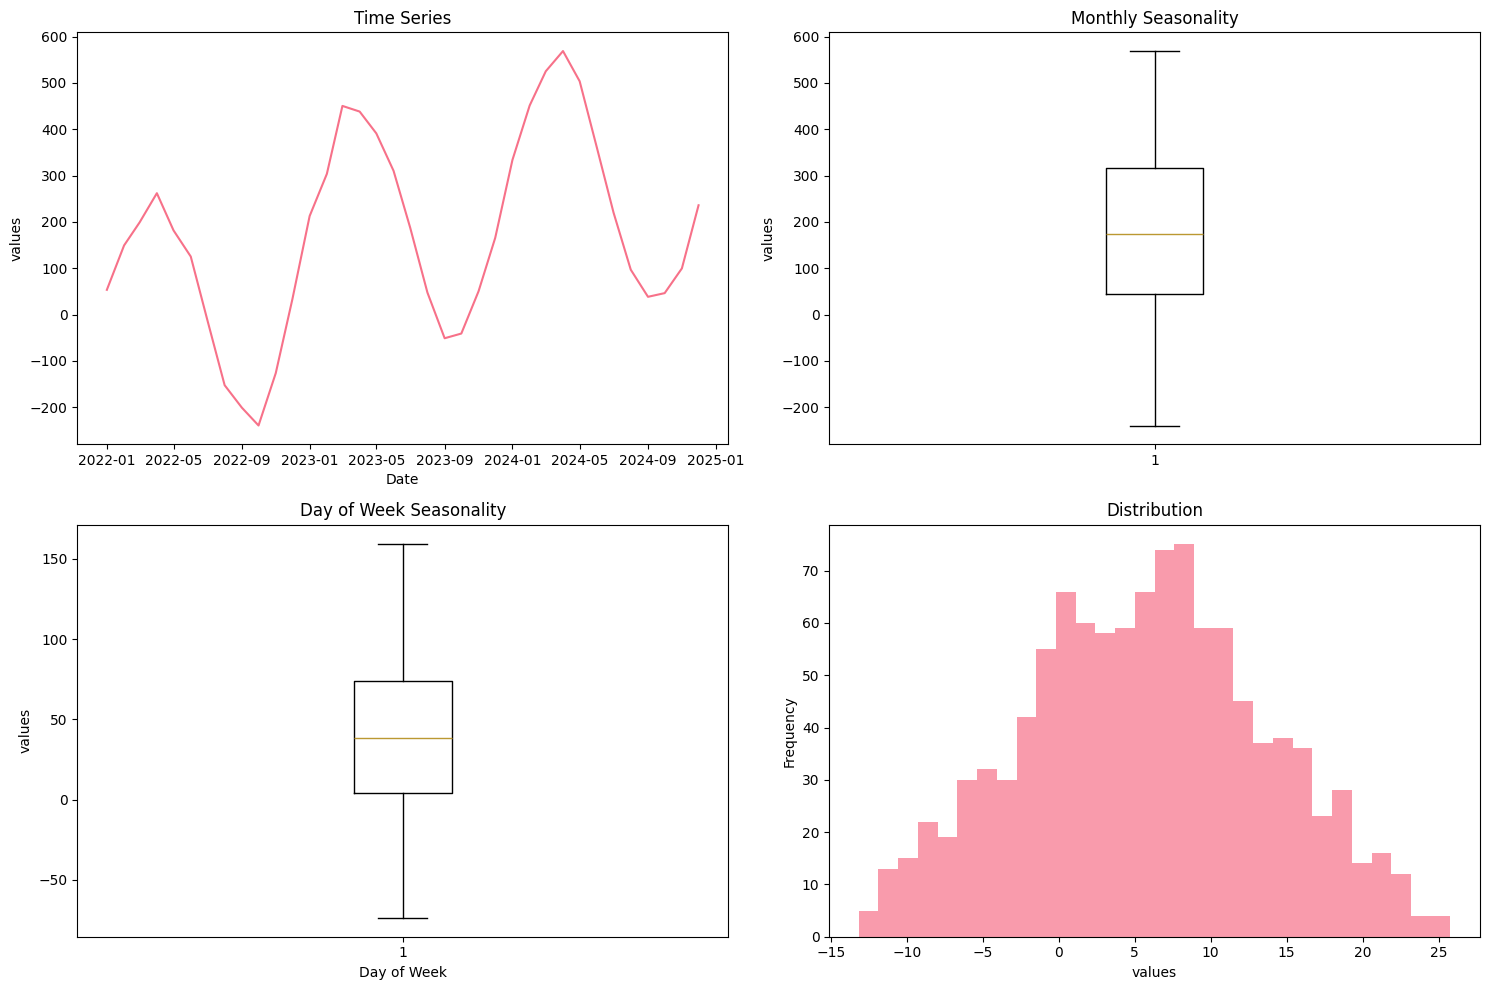

In [49]:
# look into the trend, monthly, daily outliers and the data distributions
time_series_ssd.visual_inspection()

### Auto-correlation (ACF & PACF)

- ACF: Properly check the stability or if there's any exponential decay, all lags are in the confidence interval -> White noise.

- PACF: Detect the order of auto-regressions, pay attention to the lag out of the confidence interval, those lags within the interval assuming there's no effect.


=== AUTOCORRELATION ANALYSIS ===


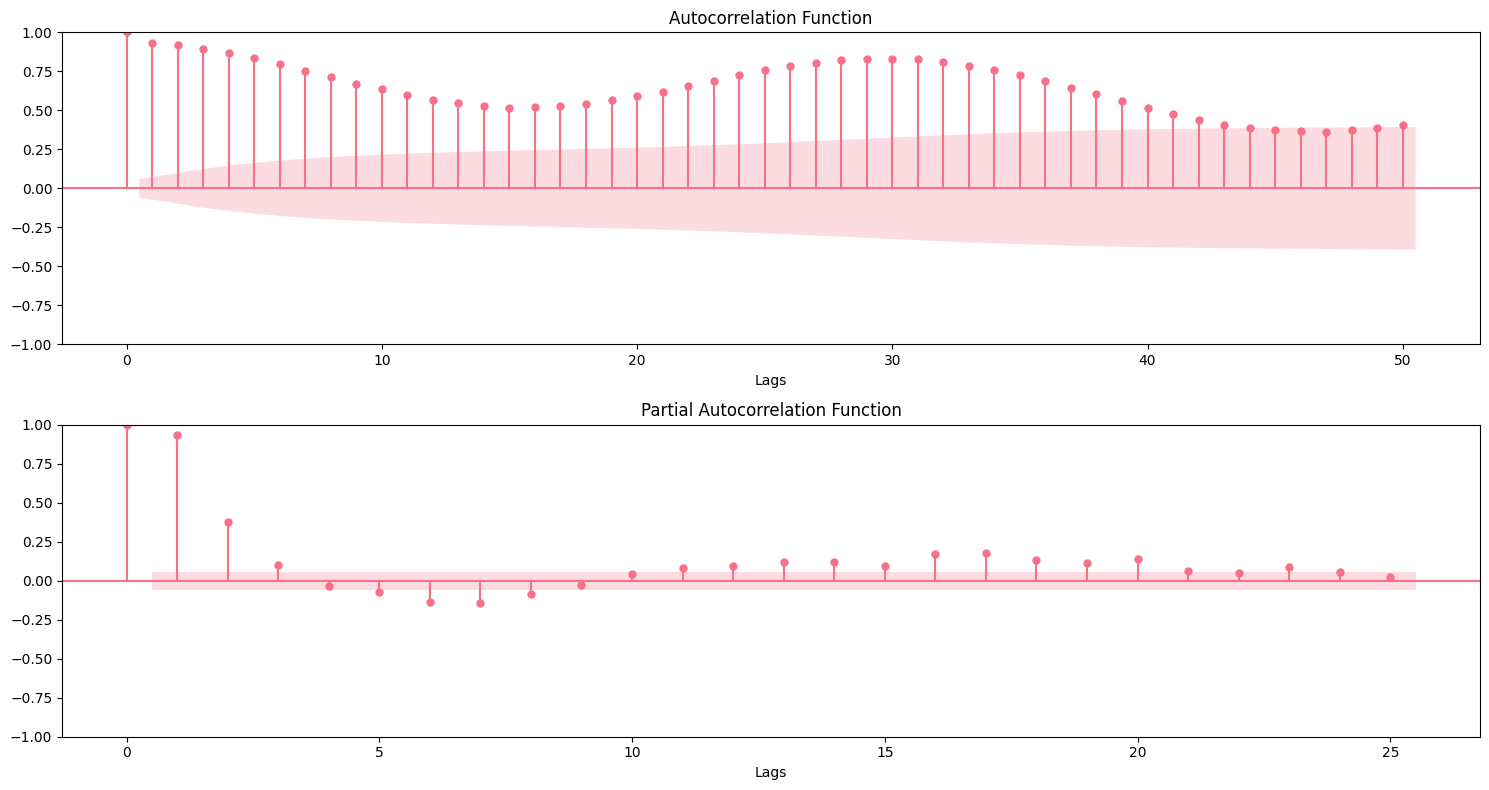


=== Overall correlation in daily ===
Lag 7 autocorrelation: 0.7557
Lag 30 autocorrelation: 0.8388
Lag 90 autocorrelation: 0.3130
Lag 180 autocorrelation: -0.3322
Lag 365 autocorrelation: 0.8924


In [50]:
# do the daily autocorrelation and see if previous days got an effect on the upcoming days
time_series_ssd.autocorrelation_analysis('daily')

### Seasonal decomposition

Default period will be 365 days to check on the trend, seasonal and the noise from the data.

I think it's not easy to get anything from the seasonal part. May be it's good to find some real sales data to check with the seanoality pattern for better observations.


=== SEASONAL DECOMPOSITION (Period: 365) ===


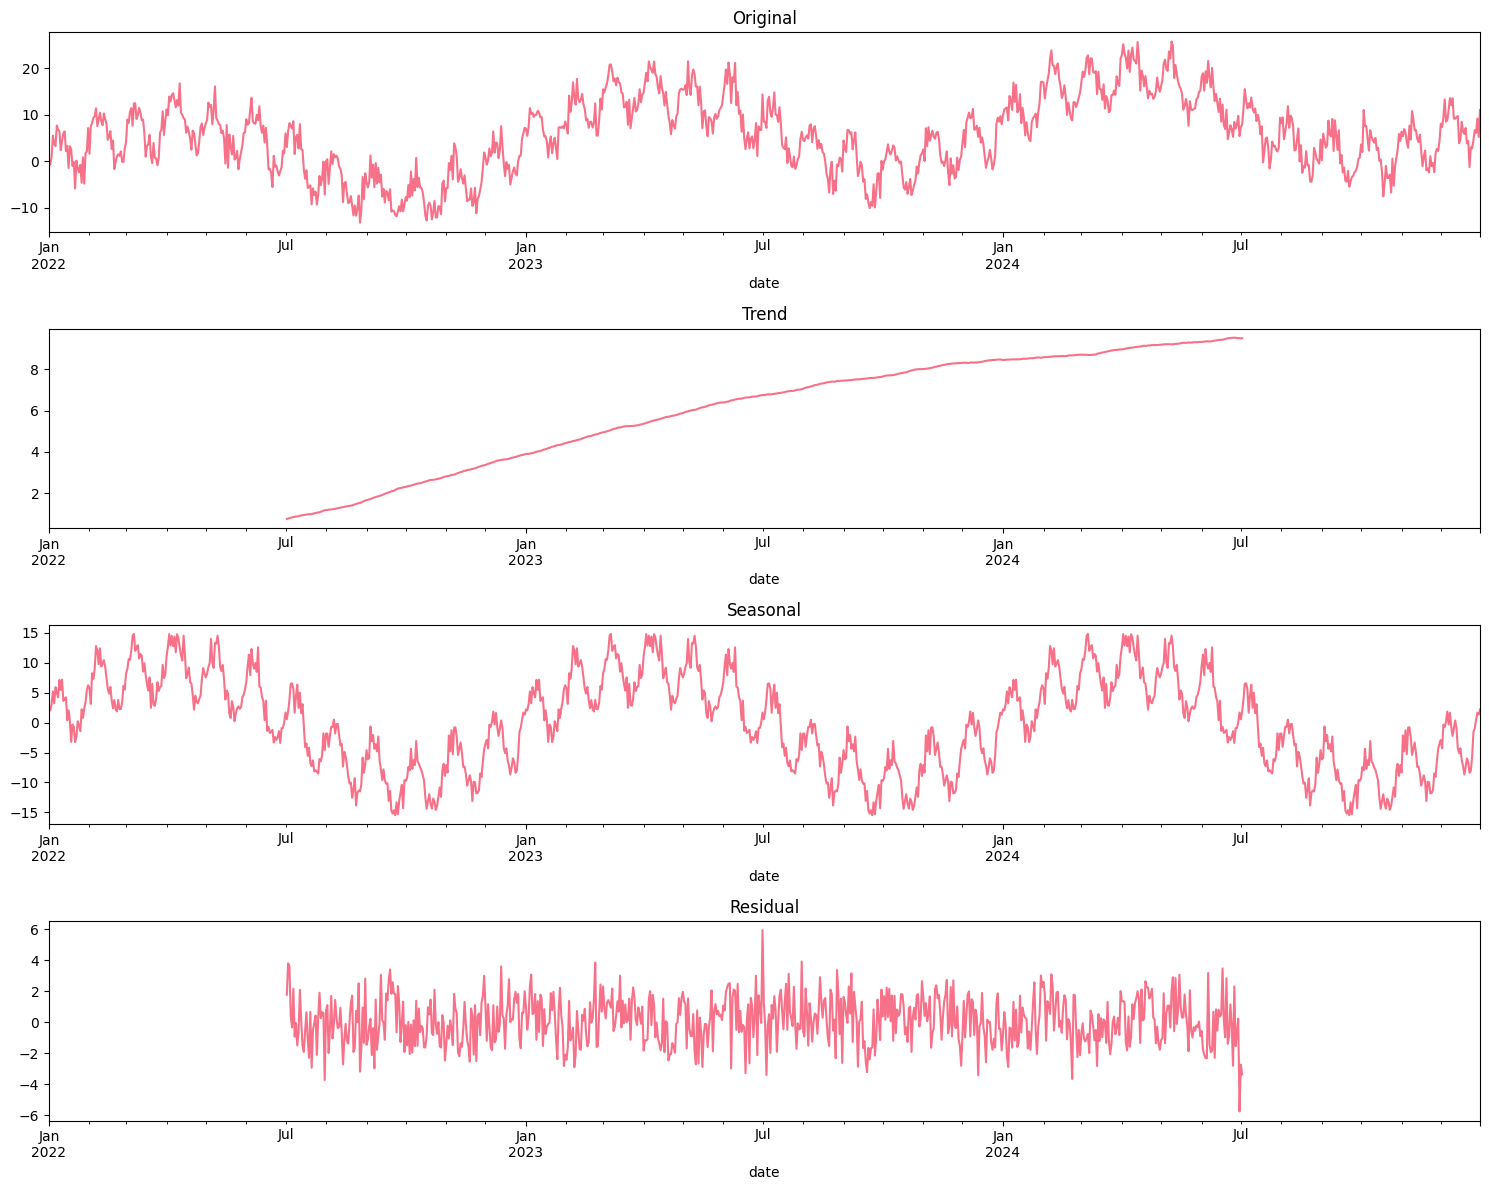

Seasonal Strength: 0.9650


In [51]:
# try to break down the data and see if there's any trend and season impact
# moving average & LOESS was used to get the trend
time_series_ssd.seasonal_decomposition()

## Day of week pattern

Based on the average to check if the some of the day of week may impact the target values. Therefore, it may help to plan say for the budget allocation and the weight across the week.

F-test is also applied to determine if there's any significant week of day effect.

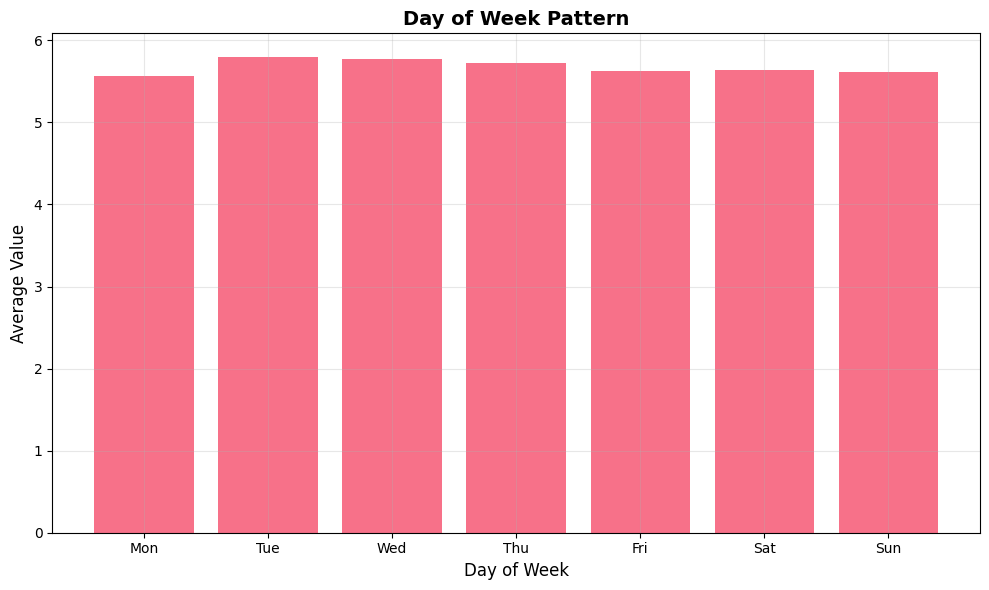


Day-of-Week Effect:
F-statistic: 0.0178, p-value: 1.0000
No significant day-of-week effect


In [52]:
time_series_ssd.day_of_week_pattern()

## Monthly Pattern

Similarly, this test checks whether any month carries significantly more weight compared to the yearly average. 

An F-test is also used to determine if a strong monthly effect is present.


Monthly Effect:
F-statistic: 101.6569, p-value: 0.0000
✓ Significant monthly effect detected!


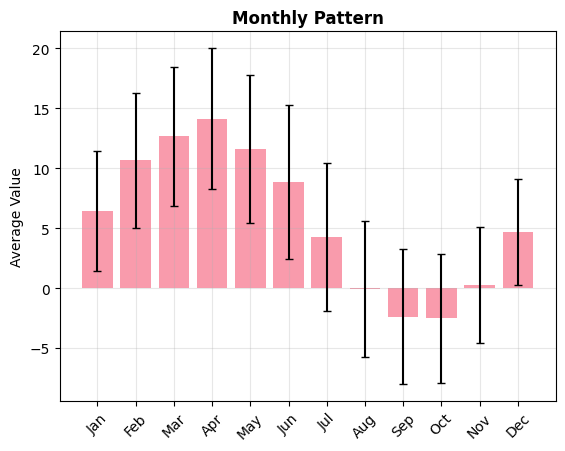

In [53]:
time_series_ssd.month_pattern()

## Week of year pattern

Similarly, this test checks whether any week out of the 52 weeks in a year carries significantly more weight compared to the yearly average.

Additionally, a one-way F-test (ANOVA) is used to determine whether a strong week-of-year effect is present.

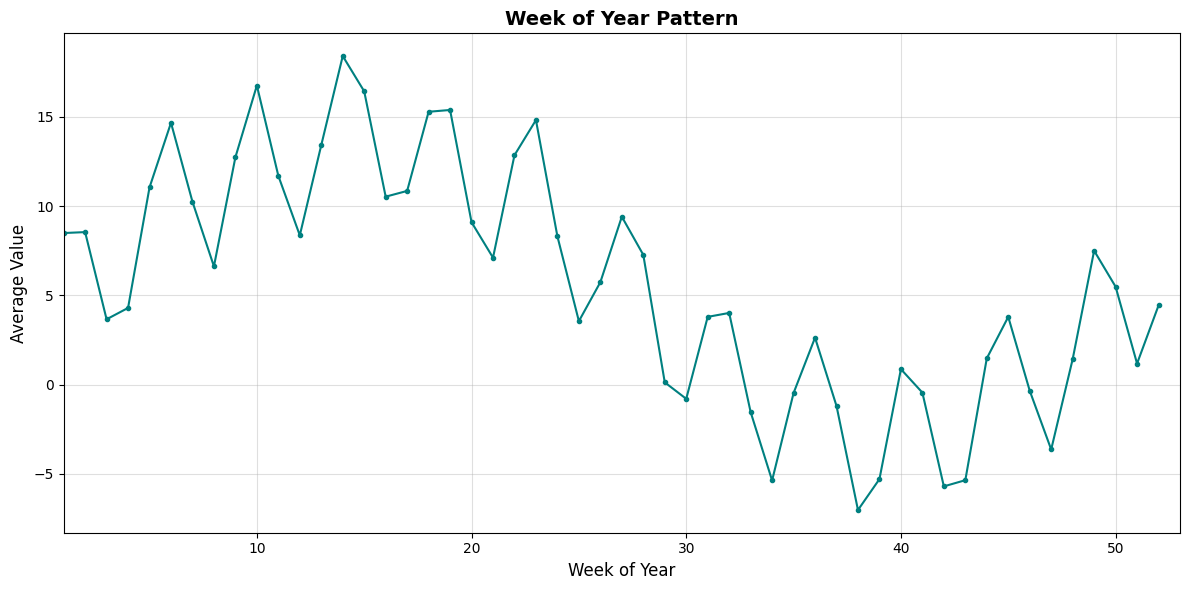


Week-of-Year Effect (ANOVA Test):
F-statistic: 43.4365, p-value: 0.0000
Significant week-of-year pattern detected!


In [54]:
time_series_ssd.week_of_year_pattern()

## Frequency domain analysis

This test is designed to check if any patterns can be found. In the example below, we can see a sharp peak at around 30 days. This indicates that a similar pattern was identified for approximately 30 days.


Frequency Analysis:
Dominant periods (days): [  30.44444444  274.          365.33333333  548.         1096.        ]


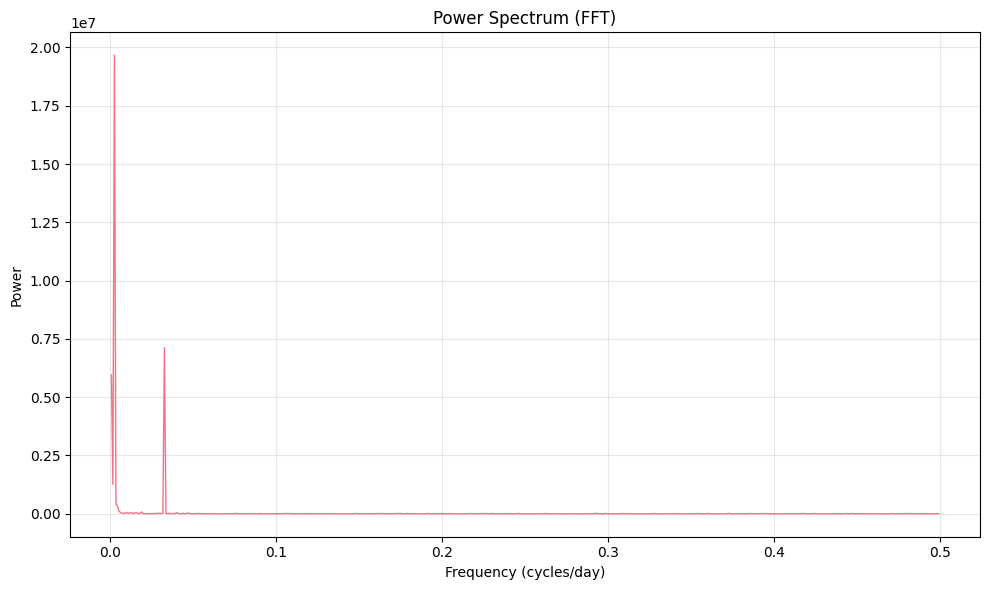

In [45]:
time_series_ssd.frequency_domain_analysis()

## Rolling statistics (ADF & Ljung-Box Test)

Based on the rolling mean and rolling standard deviation, the goal is to perform the ADF test and the Ljung-Box test.

The ADF test is used to check whether the time series is stationary. If the test rejects the null hypothesis, it means the series is stationary, making it suitable for use with the ARIMA model.

The Ljung-Box test is used to assess whether the residuals from the model are random. This test should be applied after building the ARIMA model. If your model is good, the Ljung-Box test should not be rejected, indicating that the residuals are randomly distributed and that all non-random information (such as trend, seasonality, and autocorrelation) has been successfully explained by the model.

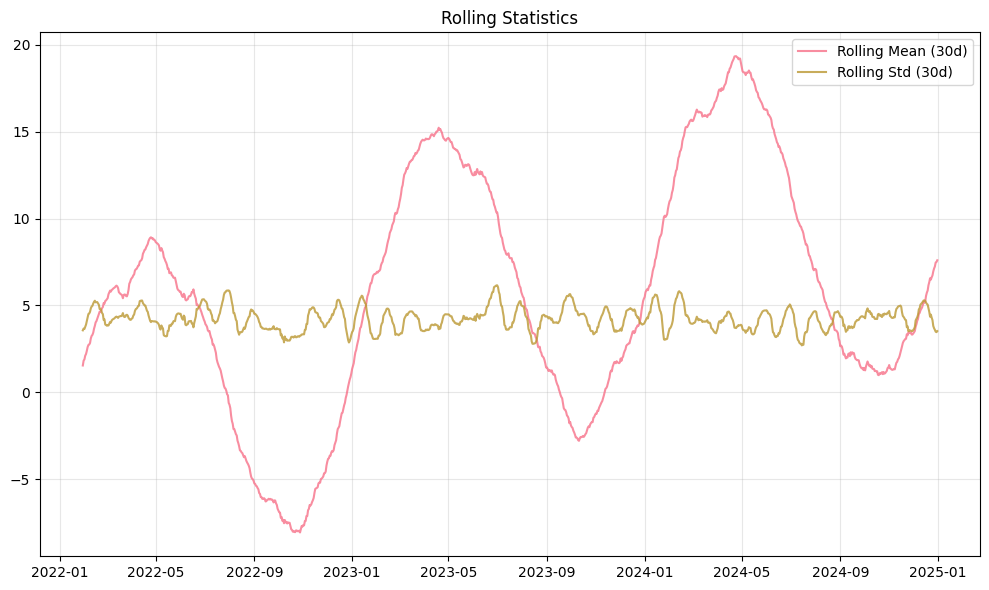


STATISTICAL TESTS
ADF Test (Stationarity):
  ADF Statistic: -1.1724
  p-value: 0.6854
  Critical Values: {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}
  Result: Series is non-stationary

Ljung-Box Test (Autocorrelation):
  Test statistic: 7200.0383
  p-value: 0.0000
  Result: Significant autocorrelation detected


In [55]:
time_series_ssd.rolling_statistics()